In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from ast import literal_eval

FILEPATH = r'..\data'

# Simple Recommender Engine - Using Weighted Ranking Formula

From IMDB.com:

`weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

Where:
- R = average for the movie (mean) = (rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top Rated list (currently 25,000)
- C = the mean vote across the whole report

In [92]:
movies = pd.read_csv(path.join(FILEPATH, 'movies_metadata.csv'), low_memory=False)
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [93]:
movies.shape

(45466, 24)

In [443]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               45466 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [481]:
def plot_score(df):
    fig, ax = plt.subplots(figsize=(10,10))
    df['vote_average'].plot(kind='hist', ax=ax, bins=20)
    ax.set_xticks(np.linspace(0, 10, num=21))
    ax.set_title('Movielens Score Distribution')

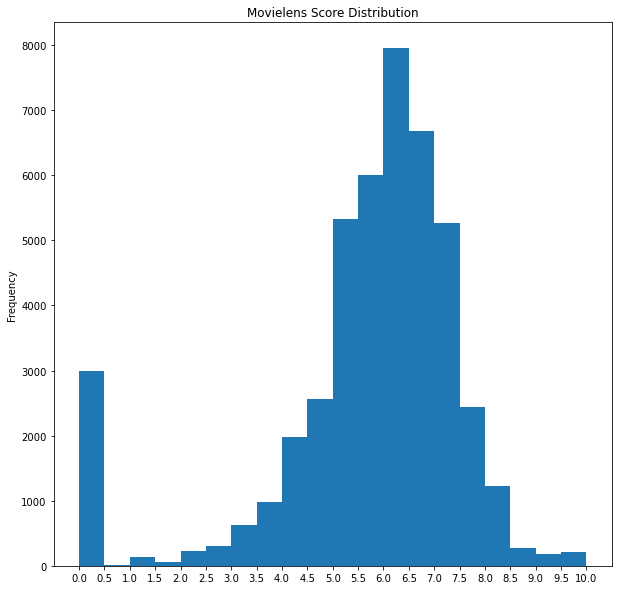

In [482]:
plot_score(movies)

In [94]:
mean_vote = movies['vote_average'].mean()
print(mean_vote)

5.618207215133889


In order to prevent lower vote / high rating movies from skewing the results, we will pick a **vote cutoff** threshold to filter the dataset.

In [95]:
number_of_votes_cutoff = movies['vote_count'].quantile(0.90)
print(number_of_votes_cutoff)

160.0


In [96]:
# Filter out DF for votecut off
movies_90Q = movies.loc[movies['vote_count'] >= number_of_votes_cutoff]
movies_90Q.shape

(4555, 24)

In [97]:
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [98]:
movies_90Q = (movies_90Q.assign(score= lambda x: x.apply(weighted_rating, m=number_of_votes_cutoff, C=mean_vote, axis='columns'))
                        .sort_values('score', ascending=False))

In [99]:
movies_90Q[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


# Content-Based Recommender

We will analyize the text from the "overview" column. We will be using **TF-IDF** (term frequency-inverse document frequency) to quantify how often a word occurs across the movie overviews, down-weighted for how often the term appears in the entire dataset. Then we will compute the "similarity score" using **cosine similarity** to quantify which movies are most similar to eachother.

In [100]:
movies['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [101]:
movies['overview'].isna().sum()

954

In [102]:
# replace nans

movies = movies.assign(overview= lambda x: x['overview'].fillna(''))

movies['overview'].isna().sum()

0

In [103]:
# instantiate the vectorizer object
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['overview'])

In [104]:
tfidf_matrix.shape

(45466, 75827)

In [105]:
# df representation of the first movie in the dataset - Toy Story
tfidf_matrix_first = tfidf_matrix[0]
df = pd.DataFrame(tfidf_matrix_first.T.todense(), index=tfidf.get_feature_names(), columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
buzz,0.502804
woody,0.480983
andy,0.411784
lightyear,0.206279
toys,0.148783
aside,0.147488
afraid,0.140912
differences,0.134831
plots,0.134348
happily,0.133115


In [107]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [108]:
cosine_sim.shape

(45466, 45466)

In [168]:
# Construct a reverse map of indices and movie titles
indices = movies[['title', 'release_date']].assign(release_date= lambda x: x['release_date'].str.split('-').str[0])

In [169]:
indices.head()

,title,release_date
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995


In [151]:
indices.index.value_counts()

Cinderella                  11
Hamlet                       9
Alice in Wonderland          9
Beauty and the Beast         8
Les Misérables               8
                            ..
American Anarchist           1
The White Diamond            1
Hail! Mafia                  1
Jarhead 2: Field of Fire     1
An American Carol            1
Name: title, Length: 42277, dtype: int64

## What about movies with the same name?
We will need to build in logic to add an additional parameter in case multiple movies share the same title. Therefore, if the count of a movie name is greater than 1, the function will ask for **the year** in which the movie was released. 

In [483]:
def get_recommendations(movie_name, cosine_sim=cosine_sim, data_source=movies, index=indices):
    # Get the index of the movie that matches the title
    movie_count = index.loc[index['title'] == movie_name, 'title'].count()
    if movie_count > 1:
        movie_year = str(input(f'There are more than one movies named {movie_name}.\n Please provide the year the movie was released >>> '))
        movie_index = index.loc[(index['title'] == movie_name) & (index['release_date'] == movie_year)].index
    else:
        movie_index = index.loc[index['title'] == movie_name].index
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[movie_index[0]]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    sim_scores = [i[1] for i in sim_scores]

    # Return the top 10 most similar movies
    return (data_source.loc[data_source.index.isin(movie_indices), ['title', 'release_date']]
                       .reindex(movie_indices)
                       .set_index('title')
                       .assign(similarity_score=sim_scores))

In [404]:
get_recommendations('Inception')

,release_date,similarity_score
title,,
III,2015-03-02,0.126486
House,1986-02-28,0.120783
Borrowed Time,2013-09-13,0.119092
The Farmer's Wife,2012-06-20,0.116644
Altitude,2017-04-14,0.116251
The Monkey's Paw,2013-10-08,0.112907
What Ever Happened to Baby Jane?,1962-10-31,0.107273
Cobb,1994-12-02,0.106512
Straight Story,2006-12-21,0.106141


In [484]:
get_recommendations('Iron Man')

There are more than one movies named Iron Man.
 Please provide the year the movie was released >>> 2008


,release_date,similarity_score
title,,
The Wonderful Ice Cream Suit,1998-01-23,0.184432
Iron Man 2,2010-04-28,0.183468
Clown,2014-11-13,0.180066
Fatal Fury: The Motion Picture,1994-07-16,0.171029
The Disappearance of Alice Creed,2009-09-12,0.146778
Iron Man 3,2013-04-18,0.145431
Girl in the Box,2016-09-10,0.139484
Sniper: Special Ops,2016-04-03,0.137804
Princess and the Pony,2011-01-25,0.134904


# Credits, Genres, and Keywords Based Recommender

We will incorporate two other datasets in this model:
- Credits
    - Director
    - Cast
- Keywords
    - genres

In [339]:
credits = pd.read_csv(path.join(FILEPATH, 'credits.csv')).assign(id= lambda x: x['id'].astype('int')).drop_duplicates()
keywords = pd.read_csv(path.join(FILEPATH, 'keywords.csv')).assign(id= lambda x: x['id'].astype('int')).drop_duplicates()

In [444]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45439 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45439 non-null  object
 1   crew    45439 non-null  object
 2   id      45439 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 1.2+ MB


In [445]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45432 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        45432 non-null  int32 
 1   keywords  45432 non-null  object
dtypes: int32(1), object(1)
memory usage: 887.3+ KB


In [446]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               45466 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

There is at least one bad id in this data set - when trying to covert the `['id']` column to `int`, there will be an error message.

In [420]:
movies.loc[movies['id'].str.contains('-')]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [342]:
# covert drop string ids, assign id to int and merge the other tables onto the main table
metadata = (movies.drop([19730, 29503, 35587]) # bad id rows
                  .assign(id= lambda x: x['id']
                  .astype('int'))
                  .merge(credits, on='id')
                  .merge(keywords, on='id')
                  .reset_index(drop=True))

In [343]:
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [344]:
type(metadata['crew'][0])

str

The newly joined data is **stringified** - we must convert to it's native python data type in order to parse further. We will use the `literal_eval` function to accomplish this.

In [345]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)
    
type(metadata['crew'][0])

list

In [346]:
metadata[features].head()

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'id': 35, 'name': 'Comedy'}]"


We want to extract the following features:
   - Director
   - Cast
   - Keywords
   - genres

In [348]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [349]:
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [350]:
metadata[features +  ['director']].head()

,cast,keywords,genres,director
0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy]","[Animation, Comedy, Family]",John Lasseter
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]",Joe Johnston
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]",Howard Deutch
3,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",Forest Whitaker
4,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence]",[Comedy],Charles Shyer


We will now clean up the string formatting to avoid confusion and to better capture related words 
- Convert to lowercase
- Remove spaces
    - Converts 'johnny cash' to 'johnnycash' so this feature isn't accidentally related to other 'johnny' actors 

In [351]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [352]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

metadata[features].head()

,cast,keywords,director,genres
0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy]",johnlasseter,"[animation, comedy, family]"
1,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,"[adventure, fantasy, family]"
2,"[waltermatthau, jacklemmon, ann-margret]","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,"[romance, comedy]"
3,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...",forestwhitaker,"[comedy, drama, romance]"
4,"[stevemartin, dianekeaton, martinshort]","[baby, midlifecrisis, confidence]",charlesshyer,[comedy]


The data has been preprocessed and is ready for analysis. We will add all features into a **word soup** so we can efficently feed our vectorizer.

In [353]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis='columns')

metadata[['soup']].head()

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...
2,fishing bestfriend duringcreditsstinger walter...
3,basedonnovel interracialrelationship singlemot...
4,baby midlifecrisis confidence stevemartin dian...


We will be using the `CountVectorizer` instead of the `TFIDFVectorizer`.

Why?
- We want to capture relative frequency in the document in this context
- If we are using directors as a feature, it would make sense to want to find movies that were directed by the same person
- TF-IDF would downweight repeat words, which would make sense when looking at something more general such as a movie overview, but not for our more precise criteria this time around

In [354]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [355]:
count_matrix.shape

(45476, 73881)

Because the vectors haven't been normalized (like they would be if we used the `TFIDFVectorizer`), we must use the `cosine_similariy` to compute similarity 

In [356]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [357]:
# Construct a reverse map of indices and movie titles
indices2 = metadata[['title', 'release_date']].assign(release_date= lambda x: x['release_date'].str.split('-').str[0])

In [358]:
indices2.shape[0] == metadata.shape[0]

True

In [384]:
get_recommendations('The Godfather', cosine_sim2, data_source=metadata, index=indices2)

,release_date,similarity_score
title,,
The Godfather: Part II,1974-12-20,0.527046
The Godfather: Part III,1990-12-24,0.421637
The Night of the Following Day,1968-12-26,0.408248
The Rain People,1969-08-27,0.384900
The Son of No One,2011-11-04,0.384900
Last Exit,2003-10-11,0.384900
In the Name of the Law,1949-03-13,0.377964
Rege,2014-08-15,0.377964
Manuscripts Don't Burn,2013-05-24,0.377964


In [400]:
get_recommendations('The Dark Knight Rises', cosine_sim2, data_source=metadata, index=indices2)

,release_date,similarity_score
title,,
The Dark Knight,2008-07-16,0.800000
Batman Begins,2005-06-10,0.700000
Shiner,2000-09-22,0.478091
Amongst Friends,1993-11-03,0.424264
Mitchell,1975-09-10,0.422577
Romeo Is Bleeding,1993-09-13,0.400000
The Prestige,2006-10-19,0.400000
Quicksand,2003-01-08,0.400000
Deadfall,1968-09-11,0.400000


In [401]:
get_recommendations('The Dark Knight', cosine_sim2, data_source=metadata, index=indices2)

There are more than one The Dark Knight.
 Please provide the year the movie was released >>> 2008


,release_date,similarity_score
title,,
The Dark Knight Rises,2012-07-16,0.800000
Batman Begins,2005-06-10,0.700000
Shiner,2000-09-22,0.478091
Amongst Friends,1993-11-03,0.424264
Mitchell,1975-09-10,0.422577
The Prestige,2006-10-19,0.400000
Hitman,2007-11-21,0.400000
Quicksand,2003-01-08,0.400000
Deadfall,1968-09-11,0.400000


## Double Weight Director

Another alternative is to increase the relative weight of the director. We accomplish this by creating a new `soup` column and adding the `director` feature twice. 

In [421]:
metadata_dir = metadata.copy()

In [422]:
metadata_dir = metadata_dir.assign(soup_2 = lambda x: x['soup'] + x['director'])

metadata_dir.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,cast,crew,keywords,director,soup,soup_2
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...,jealousy toy boy tomhanks timallen donrickles ...
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...,boardgame disappearance basedonchildren'sbook ...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,fishing bestfriend duringcreditsstinger walter...,fishing bestfriend duringcreditsstinger walter...
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",forestwhitaker,basedonnovel interracialrelationship singlemot...,basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",charlesshyer,baby midlifecrisis confidence stevemartin dian...,baby midlifecrisis confidence stevemartin dian...


In [424]:
count_dir = CountVectorizer(stop_words='english')
count_matrix_dir = count_dir.fit_transform(metadata_dir['soup_2'])

In [425]:
cosine_sim3 = cosine_similarity(count_matrix_dir, count_matrix_dir)

In [426]:
indices3 = metadata_dir[['title', 'release_date']].assign(release_date= lambda x: x['release_date'].str.split('-').str[0])

In [427]:
get_recommendations('The Godfather', cosine_sim3, data_source=metadata_dir, index=indices3)

,release_date,similarity_score
title,,
The Godfather: Part II,1974-12-20,0.421637
The Godfather: Part III,1990-12-24,0.421637
Apocalypse Now,1979-08-15,0.333333
Ill Gotten Gains,1997-12-05,0.333333
"Jails, Hospitals & Hip-Hop",NaN,0.333333
Gardens of Stone,1987-05-05,0.333333
Sundome,2007-11-20,0.333333
Home Sweet Home,2001-03-09,0.333333
Joni,1979-06-01,0.333333


In [433]:
get_recommendations('Terminator 2: Judgment Day', cosine_sim3, data_source=metadata_dir, index=indices3)

,release_date,similarity_score
title,,
The Terminator,1984-10-26,0.572078
T2 3-D: Battle Across Time,1996-01-01,0.455842
Evil Behind You,2006-10-31,0.426401
2047: Sights of Death,2014-06-13,0.402015
Hands of Steel,1986-03-26,0.381385
Nemesis 2 - Nebula,1995-09-26,0.363636
Aliens of the Deep,2005-01-21,0.363636
Double Dragon,1994-11-04,0.363636
The Book of Eli,2010-01-14,0.363636
